In [167]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif', weight='ultralight')
rc('figure', facecolor='w')
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import os, math
import apogee_tools as ap

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [189]:
sample = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/apogee_test/test_results/safe_sample_results.csv')

In [100]:
sample.keys()

Index(['bp_rp', 'chi', 'dec', 'dist', 'fe_h', 'gaia_id', 'g_abs', 'h', 'id',
       'j', 'k', 'plx', 'plx_err', 'pmdec', 'pmdec_err', 'pmra', 'pmra_err',
       'ra', 'rv', 'rv_err', 'teff', 'x', 'y', 'z'],
      dtype='object')

In [3]:
allstar = fits.open('/home/jess/Desktop/Research/data/apogee_data/apogee_x_gaiadr2_full_info.fits')

In [6]:
allstar[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                 6937 / width of table in bytes                        
NAXIS2  =               254478 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                  318 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'dist    '           / label for column 1                             
TFORM1  = 'D       '           / format for column 1                            
TTYPE2  = 'table1_oid'         / label for column 2                             
TFORM2  = 'J       '        

In [125]:
keys = ['APOGEE_ID_1', 'ra_APOGEE', 'dec_APOGEE', 'source_id', 'parallax', 'parallax_error', \
       'pmra_1', 'pmra_error', 'pmdec_1', 'pmdec_error',  'astrometric_n_good_obs_al', \
       'phot_g_mean_flux', 'phot_g_mean_flux_error', \
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', \
       'phot_bp_rp_excess_factor', 'visibility_periods_used', 'astrometric_chi2_al', \
       'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'J', 'H', 'K', 'TEFF', 'LOGG', 'M_H']

In [140]:
data = {}
for k in keys:
    data[k] = np.array(allstar[1].data[k]).byteswap().newbyteorder()
df = pd.DataFrame(data=data)

In [141]:
df = df[df['parallax'] > 0]
df['g_abs2'] = df['phot_g_mean_mag'] + 5*np.log10(df['parallax'])-10

a1 = df['astrometric_chi2_al']/(df['astrometric_n_good_obs_al']-5)
a2 = 1.44*max(np.exp(-0.4*(df['phot_g_mean_mag']-19.5)))

In [142]:
df = df[df['parallax']/df['parallax_error'] > 10]
df = df[df['phot_g_mean_flux']/df['phot_g_mean_flux_error']>20]
df = df[df['phot_bp_mean_flux']/df['phot_bp_mean_flux_error']>20]
df = df[df['phot_rp_mean_flux']/df['phot_rp_mean_flux_error']>20]
df = df[df['visibility_periods_used']>9]
df = df[a1 < a2]
df = df[df['g_abs2'] > 7]

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [143]:
for x in sample['id']:
    df = df[df['APOGEE_ID_1'] != x]
len(df)

9799

In [155]:
df.to_csv('xmatch/apogee_gaia_non_mdarfs.csv')

In [156]:
pairs = pd.read_csv('xmatch/apogee_gaia_200_arcsec_pairs.csv')

In [157]:
np.array(pairs.keys())

array(['bp_rp', 'chi', 'dec', 'dist', 'fe_h', 'gaia_id', 'g_abs', 'h_1',
       'id', 'j_1', 'k_1', 'plx', 'plx_err', 'pmdec', 'pmdec_err', 'pmra',
       'pmra_err', 'ra', 'rv', 'rv_err', 'teff_1', 'x', 'y', 'z', 'col1',
       'APOGEE_ID_1', 'H_2', 'J_2', 'K_2', 'LOGG', 'M_H', 'TEFF_2',
       'astrometric_chi2_al', 'astrometric_n_good_obs_al', 'dec_APOGEE',
       'parallax', 'parallax_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_bp_rp_excess_factor', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'pmdec_1',
       'pmdec_error', 'pmra_1', 'pmra_error', 'ra_APOGEE', 'source_id',
       'visibility_periods_used', 'g_abs2', 'Separation'], dtype=object)

In [158]:
pairs['cpm_crit'] = (pairs['pmra'] - pairs['pmra_1'])**2 / (pairs['pmra_err']**2 + pairs['pmra_error']**2) + \
    (pairs['pmdec'] - pairs['pmdec_1'])**2 / (pairs['pmdec_err']**2 + pairs['pmdec_error']**2)

In [159]:
cpm = pairs[pairs['cpm_crit'] < 25]

In [160]:
cpm

,bp_rp,chi,dec,dist,fe_h,gaia_id,g_abs,h_1,id,j_1,...,pmdec_1,pmdec_error,pmra_1,pmra_error,ra_APOGEE,source_id,visibility_periods_used,g_abs2,Separation,cpm_crit
87,2.271121,47695.384784,-5.610987,0.297498,-0.246463,3217260534288646528,9.699963,12.153,2M05352032-0536394,12.740,...,0.448192,0.130073,1.105504,0.157437,83.831221,3017252462889247744,11,7.490146,17.444860,7.827915
100,2.442505,5076.685157,23.107815,0.095563,-0.254815,1268422009945067392,10.128538,11.798,2M15004751+2306262,12.391,...,113.734171,0.124152,-171.700626,0.121670,225.195121,1262819551525306624,12,10.993808,23.554441,14.899824
205,2.361516,14587.848114,-4.831298,0.382055,-0.072332,3209528734163677056,8.472661,12.494,2M05353172-0449526,13.167,...,-0.913636,0.094733,1.292328,0.106603,83.888914,3209572061793574912,11,7.690861,82.283192,3.619985
241,2.135352,18802.028469,2.229792,0.336768,-0.412355,773204137458157312,9.135789,13.790,2M11455989+0213475,14.329,...,-12.466970,0.039631,-0.621265,0.066812,176.501834,3799519939116533760,10,7.357666,7.973539,0.374475
321,1.934366,13933.171587,20.828010,0.133228,-0.001604,1605846288670365696,8.286158,11.015,2M14594276+2049387,11.728,...,111.892536,0.088447,-41.368374,0.063107,224.951847,1261431280655790208,10,7.058333,134.737577,14.595097
328,2.791128,14871.716694,23.739715,0.133651,0.059503,422083242392974336,10.394688,12.428,2M03480796+2344238,13.030,...,-45.251634,0.327853,19.907759,0.463270,57.063609,65000623470665216,10,9.748299,171.589407,15.558880


In [171]:
cpm['M_H']

87    -9999.000000
100      -0.372695
205   -9999.000000
241      -0.479713
321       0.084134
328       0.117050
Name: M_H, dtype: float64

['2M05352032-0536394' '2M05352032-0536394'] [4611 4612]
aspcapStar-r8-l31c.2-2M05352032-0536394.fits successfully downloaded. 



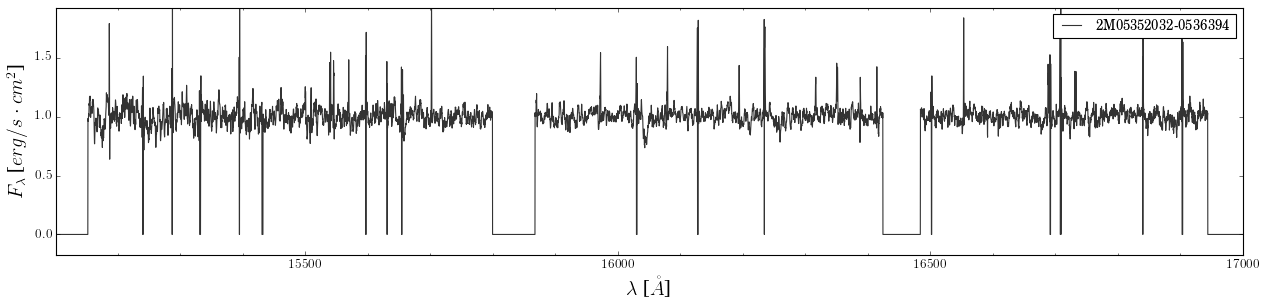

['2M15004751+2306262'] [4437]
aspcapStar-r8-l31c.2-2M15004751+2306262.fits successfully downloaded. 



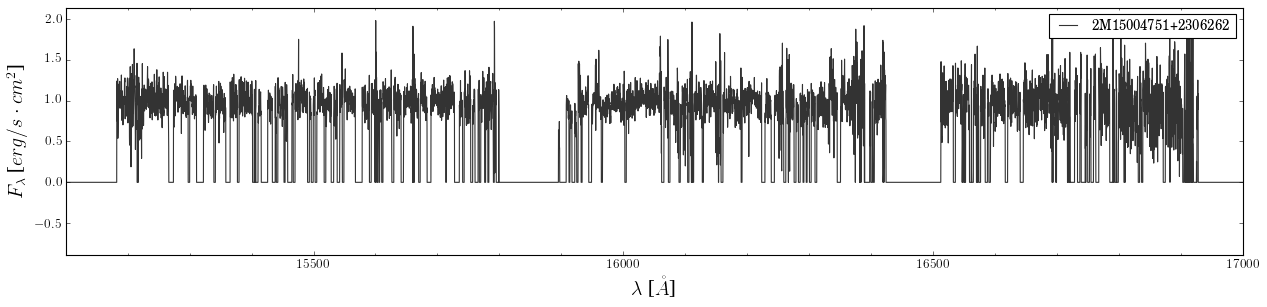

['2M05353172-0449526'] [4612]
aspcapStar-r8-l31c.2-2M05353172-0449526.fits successfully downloaded. 



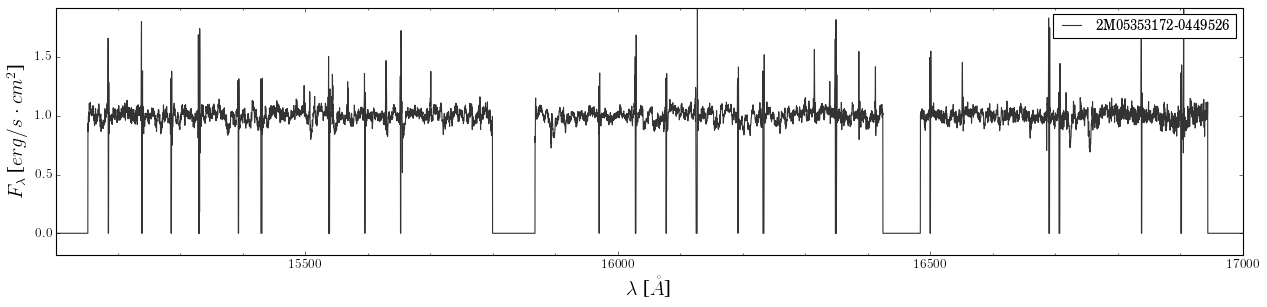

['2M11455989+0213475'] [5109]
aspcapStar-r8-l31c.2-2M11455989+0213475.fits successfully downloaded. 



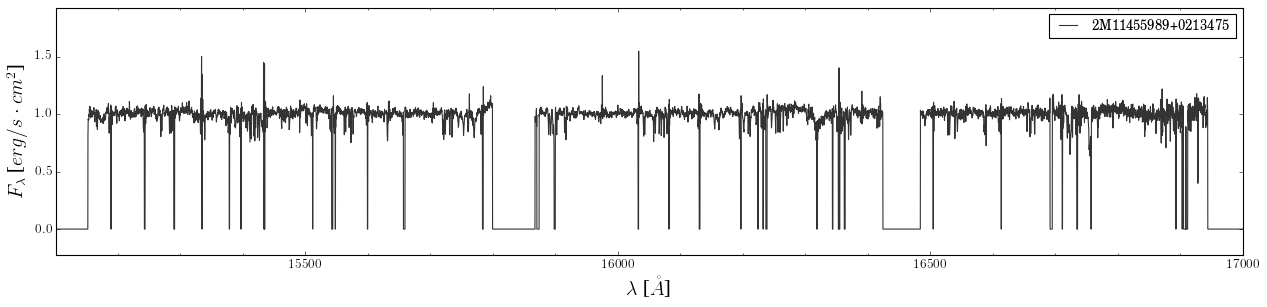

['2M14594276+2049387'] [4437]
aspcapStar-r8-l31c.2-2M14594276+2049387.fits successfully downloaded. 



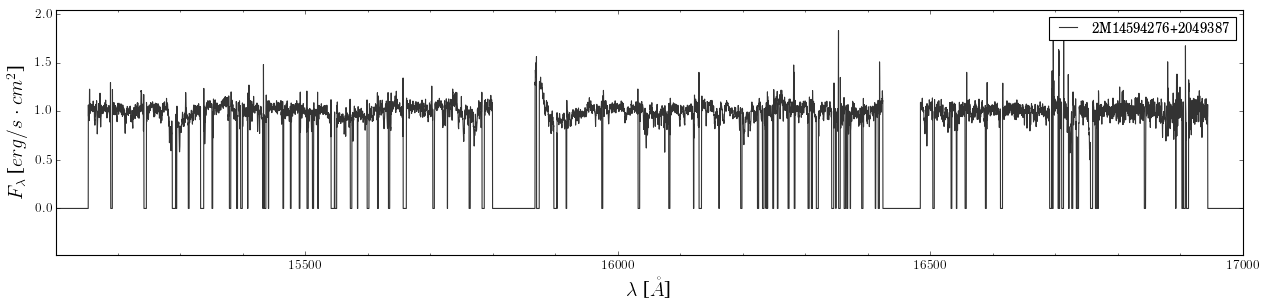

['2M03480796+2344238'] [4259]
aspcapStar-r8-l31c.2-2M03480796+2344238.fits successfully downloaded. 



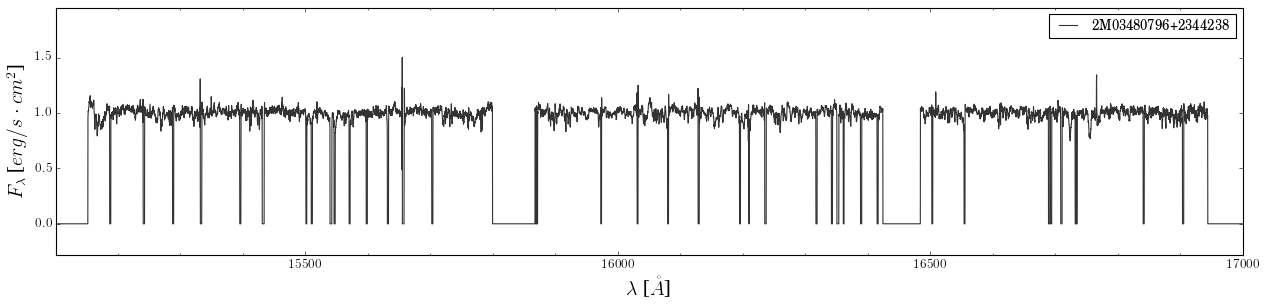

In [170]:
for ID in cpm['id']:
    sp = ap.Apogee(id=ID, type='aspcap')
    sp.plot()

In [174]:
len(sample)/3

2358.0

In [179]:
sample[0:10].to_csv('/home/jess/Downloads/blah1.csv')

In [185]:
max(sample['dist'])

1.1365395768736373

In [184]:
max(sample['plx']), min(sample['plx'])

(296.3072923655969, 0.8798637727607985)

In [193]:
len(sample[sample['DIST'] < 1])

10307

In [194]:
1/.6

1.6666666666666667